In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle')

iic_burden.keys()

sns.set(font_scale=4,style='whitegrid')

df_pkpd = pd.read_csv('PD_Parameters_result.csv',index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

# Some functions!

In [4]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
        
def policy(Et,a,step):
    t = len(Et)
    X = np.zeros((36//step,1))
    if t>1:
        X[0] = np.nanmean(Et[t-1:t])
    if t>3:
        X[1] = np.nanmean(Et[t-3:t])
    if t>6:
        X[2] = np.nanmean(Et[t-6:t])
        X[5] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t])
    if t>12:
        X[3] = np.nanmean(Et[t-12:t])
        X[6] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t]) * np.nanmean(Et[t-12:t])
    if t>36:
        X[4] = np.nanmean(Et[t-36:t])
        X[7] = (1-np.nanmean(Et[t-3:t]))*(1-np.nanmean(Et[t-6:t]))*(1-np.nanmean(Et[t-12:t])) * (1-np.nanmean(Et[t-36:t]))
        X[8] = 1
    # for s in range(0,min(t,36),step):
    #     X[s//step] = np.nanmean(Et[t-s:t])
    A = np.matmul(a,X)
    return A

def objective_infer_policy(E,D,a,step):
    a0 = a.reshape((D.shape[1],36//step))
    loss = 0
    T = E.shape[0]
    for t in range(0,T):
        Et = E[:t]
        A = policy(Et,a0,step)
        loss += np.linalg.norm(A-D[t,:])
    regularization = np.linalg.norm(a)
    # cons = 1e+2*np.sum(a0<0)
    return loss + regularization#+cons

def infer_policy(i,step=2):
    E = iic_burden['Pobs'][i]
    D = iic_burden['Ddose'][i][:,[1,5]]
    f = lambda a: objective_infer_policy(E,D,a,step)
    a0 = np.zeros((D.shape[1]*(36//step),))
    res = opt.minimize(fun=f,x0=a0,method='COBYLA')
    return res.x
    

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['Ddose'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        


# Approach 2

In [5]:
def get_features(E,D):
    T = len(E)
    Xf = []
    for t in range(T):
        Et = E[:t]
        Dt = D[:t,:]
        X = np.zeros((14,))
        X[0] = 1
        if t>1:
            X[1] = np.nanmean(Et[t-1:t])
            X[9] = np.nanmean(Dt[t-1:t,1])
        if t>3:
            X[2] = np.nanmean(Et[t-3:t])
            # X[10] = np.nanmean(Dt[t-3:t,1])
        # if t>6:
        #     X[3] = np.nanmean(Et[t-6:t])
        #     X[6] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t])
        #     X[11] = np.nanmean(Dt[t-6:t,0])
        # if t>12:
        #     X[4] = np.nanmean(Et[t-12:t])
        #     X[7] = np.nanmean(Et[t-3:t]) * np.nanmean(Et[t-6:t]) * np.nanmean(Et[t-12:t])
        #     X[12] = np.nanmean(Dt[t-12:t,0])
        if t>36:
            X[5] = np.nanmean(Et[t-36:t])
            # X[8] = (1-np.nanmean(Et[t-3:t]))*(1-np.nanmean(Et[t-6:t]))*(1-np.nanmean(Et[t-12:t]))
            # X[13] = np.nanmean(Dt[t-36:t,0])
        Xf.append(X)
    return np.array(Xf)

def get_policy(i):
    E = iic_burden['Pobs'][i]
    D = np.array(iic_burden['Ddose'][i])[:,[1,5]]
    X = pd.DataFrame(get_features(E,D),
                     columns=['1','E[10]','E[30]',
                              'E[60]','E[120]',
                              'E[360]','E[30]E[60]',
                              'E[30]E[60]E[120]',
                              '1-E','Prop10','Prop30',
                              'Lev1','Lev2','Lev6'])
    X['lev'] = iic_burden['Ddose'][i][:,1]
    X['prop'] = iic_burden['Ddose'][i][:,5]
    X = X.dropna()
    m1 = lm.RidgeCV()
    multi_target_lr = MultiOutputRegressor(m1, n_jobs=-1)
    multi_target_lr = multi_target_lr.fit(X.drop(columns=['lev','prop']), X[['lev','prop']])
    return multi_target_lr
    
    

In [6]:
N = len(iic_burden['Pobs'])

lev_policy = pd.DataFrame()
prop_policy = pd.DataFrame()

for i in tqdm.tqdm(range(0,N)):
    m1 = get_policy(i)
    c_lev = pd.Series(m1.estimators_[0].coef_,index=['1','E[10]','E[30]',
                                                      'E[60]','E[120]',
                                                      'E[360]','E[30]E[60]',
                                                      'E[30]E[60]E[120]',
                                                      '1-E','Prop10','Prop30',
                                                      'Lev1','Lev2','Lev6'])
    c_prop = pd.Series(m1.estimators_[1].coef_,index=['1','E[10]','E[30]',
                                                      'E[60]','E[120]',
                                                      'E[360]','E[30]E[60]',
                                                      'E[30]E[60]E[120]',
                                                      '1-E','Prop10','Prop30',
                                                      'Lev1','Lev2','Lev6'])
    
    lev_policy = lev_policy.append(c_lev,ignore_index=True)
    prop_policy = prop_policy.append(c_prop,ignore_index=True)

100%|██████████| 1323/1323 [00:52<00:00, 25.22it/s]


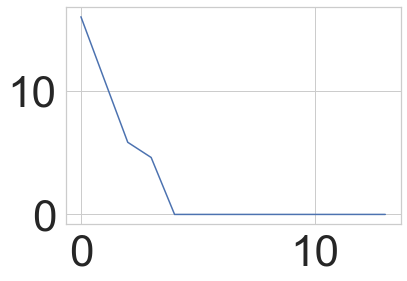

In [7]:
p_dm = prop_policy - np.mean(prop_policy,axis=0)
u,s,v = np.linalg.svd(p_dm)
plt.plot(s)

<AxesSubplot:>

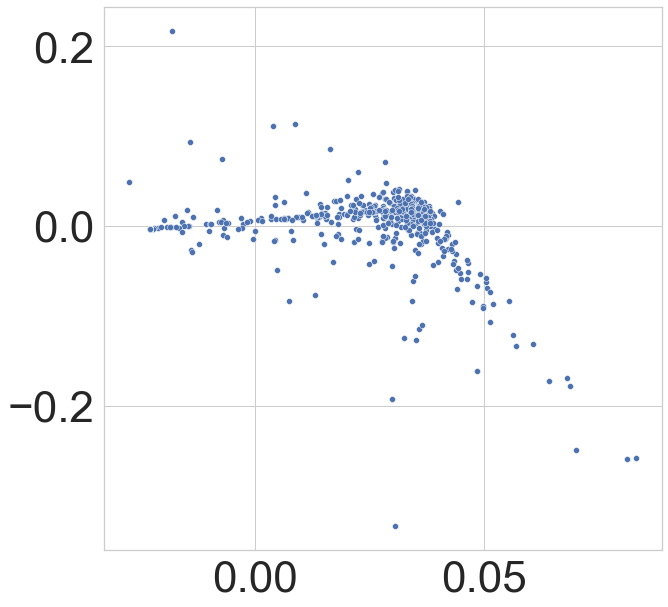

In [16]:
from sklearn.cluster import *
U2 = u[:,:2]
c = KMeans(n_clusters=3).fit(X=U2)
clus = prop_policy.copy(deep=True)
clus.index = iic_burden['sids']
clus['c']=c.labels_

plt.figure(figsize=(10,10))
sns.scatterplot(u[:,0],u[:,1])#,hue=clus['c'],palette='tab10')

In [218]:
from sklearn.cluster import *

c = KMeans(n_clusters=4).fit(X=prop_policy)


In [219]:
clus = prop_policy.copy(deep=True)
clus.index = iic_burden['sids']
clus['c']=c.labels_

In [220]:
clus['c'].unique()

array([0, 1, 2], dtype=int32)

No handles with labels found to put in legend.


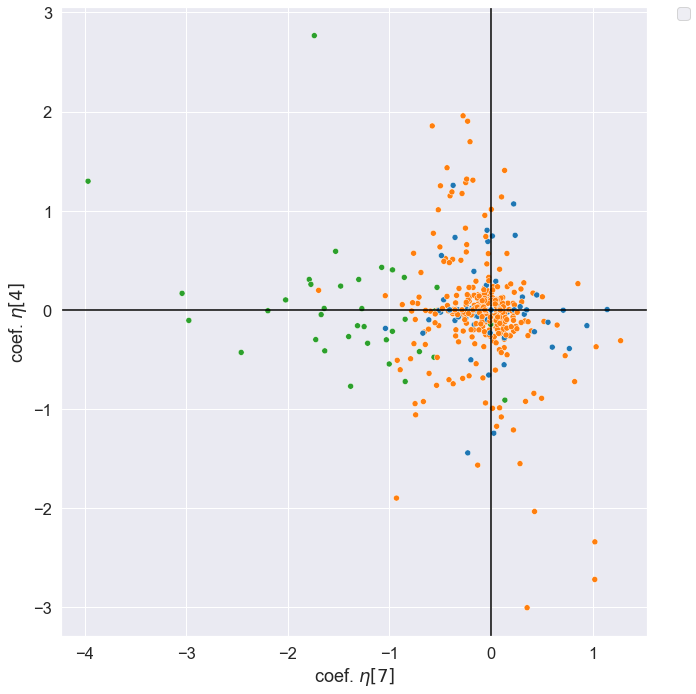

In [221]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=clus['1-E'],y=clus['E[360]'],hue=clus['c'],palette='tab10',legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0,c='black')
plt.axhline(0,c='black')
plt.ylabel(r'coef. $\eta[4]$')
plt.xlabel(r'coef. $\eta[7]$')
plt.tight_layout()
plt.savefig('prelim_e360_vs_1_minus_e.png')

No handles with labels found to put in legend.


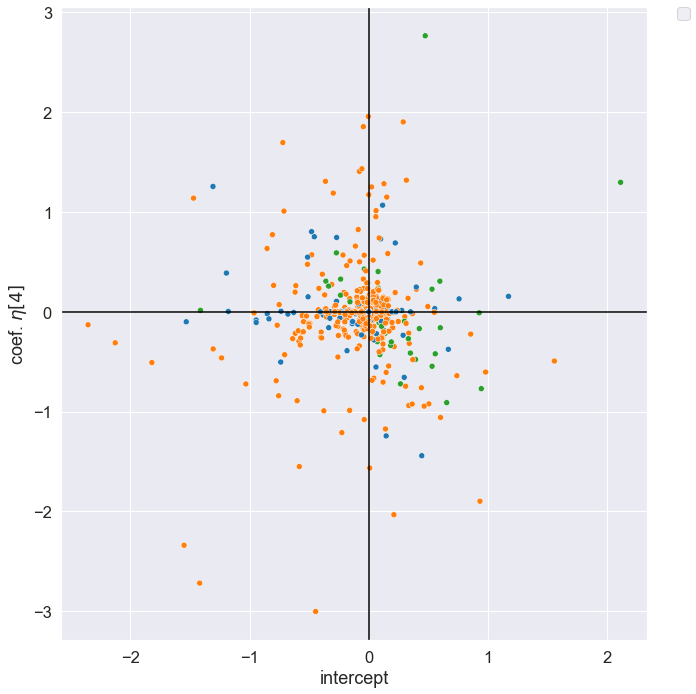

In [222]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=clus['1'],y=clus['E[360]'],hue=clus['c'],palette='tab10',legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0,c='black')
plt.axhline(0,c='black')
plt.ylabel(r'coef. $\eta[4]$')
plt.xlabel('intercept')
plt.tight_layout()
plt.savefig('prelim_e360_vs_intercept.png')

No handles with labels found to put in legend.


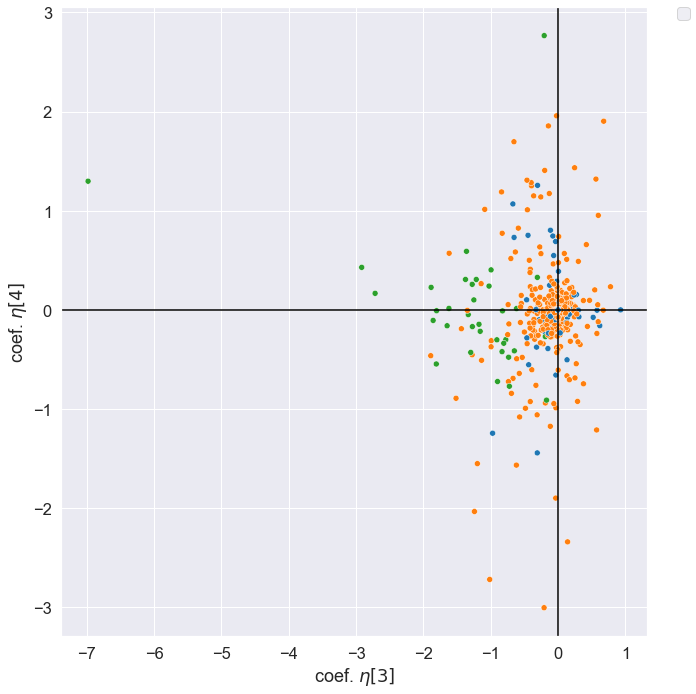

In [223]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=clus['E[120]'],y=clus['E[360]'],hue=clus['c'],palette='tab10',legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0,c='black')
plt.axhline(0,c='black')
plt.ylabel(r'coef. $\eta[4]$')
plt.xlabel(r'coef. $\eta[3]$')
plt.tight_layout()
plt.savefig('prelim_e360_vs_e120.png')

In [224]:
clus.to_csv('prelim_pol_prop.csv')

In [225]:
df_C = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
df = df_C.join(clus)
df['Y'] =iic_burden['Y']>4

In [253]:
df.groupby(by='c').mean()[['Prop10','1-E','Y','APACHE II 1st 24h','Worst GCS in 1st 24h','NeuroDx:IschStroke','NeuroDx:HemStroke','NeuroDx:Sz/SE']].round(decimals=2)

,Prop10,1-E,Y,APACHE II 1st 24h,Worst GCS in 1st 24h,NeuroDx:IschStroke,NeuroDx:HemStroke,NeuroDx:Sz/SE
c,,,,,,,,
0,0.03,-0.00,0.42,16.01,10.03,0.08,0.15,0.25
1,0.87,-0.06,0.60,22.19,5.69,0.08,0.16,0.30
2,0.58,-1.41,0.42,21.94,5.50,0.00,0.08,0.33


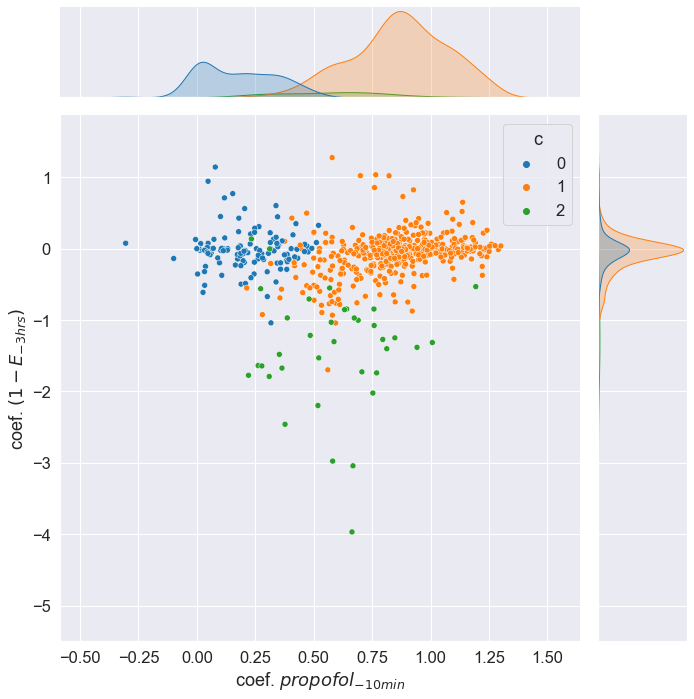

In [252]:
fig = sns.jointplot(data=df.loc[df['Prop10']!=0],x='Prop10',y='1-E',hue='c',palette='tab10',height=10, ratio=5)
fig.set_axis_labels(xlabel=r'coef. $propofol_{-10 min}$',ylabel=r'coef. $(1-E_{-3hrs})$')
plt.savefig('prelim_prop10_vs_1minus_e.png')

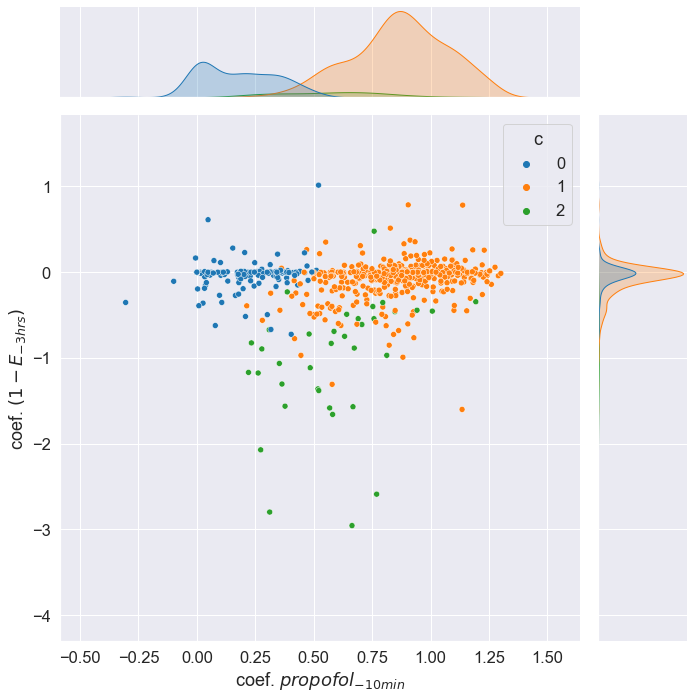

In [255]:
fig = sns.jointplot(data=df.loc[df['Prop10']!=0],x='Prop10',y='E[30]',hue='c',palette='tab10',height=10, ratio=5)
fig.set_axis_labels(xlabel=r'coef. $propofol_{-10 min}$',ylabel=r'coef. $(1-E_{-3hrs})$')
plt.savefig('prelim_prop10_vs_1minus_e.png')

Text(0.5, 0, 'coef. $prop_{-10 min}$')

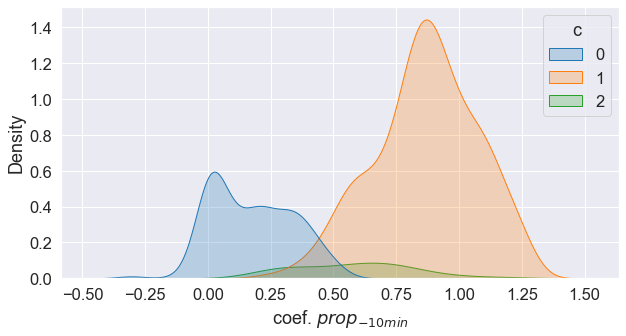

In [237]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df.loc[df['Prop10']!=0],x='Prop10',hue='c',palette='tab10',fill=True)
plt.xlabel(r'coef. $prop_{-10 min}$')

Text(0.5, 0, 'coef. $1-E$')

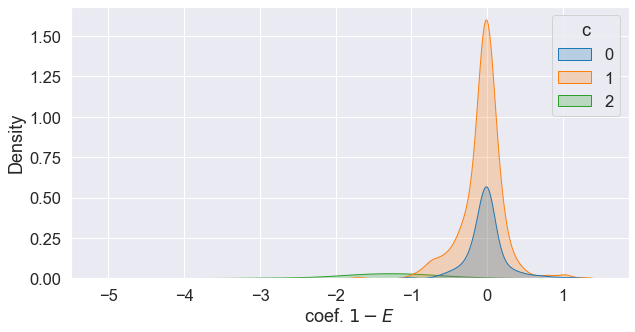

In [238]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df.loc[df['1-E']!=0],x='1-E',hue='c',palette='tab10',fill=True)
plt.xlabel(r'coef. $1-E$')

# Plotting

In [155]:
sns.set(font_scale=1.5)
plot_u = lambda i: plot_unit(iic_burden['Pobs'][i],iic_burden['D'][i][:,[1,5]],Dnames=['Lev','Prop'])

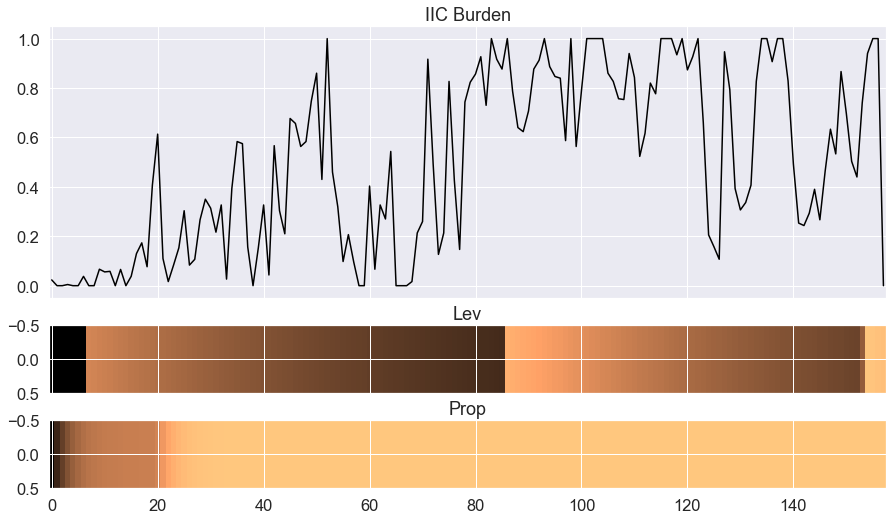

In [81]:
plot_u(2)

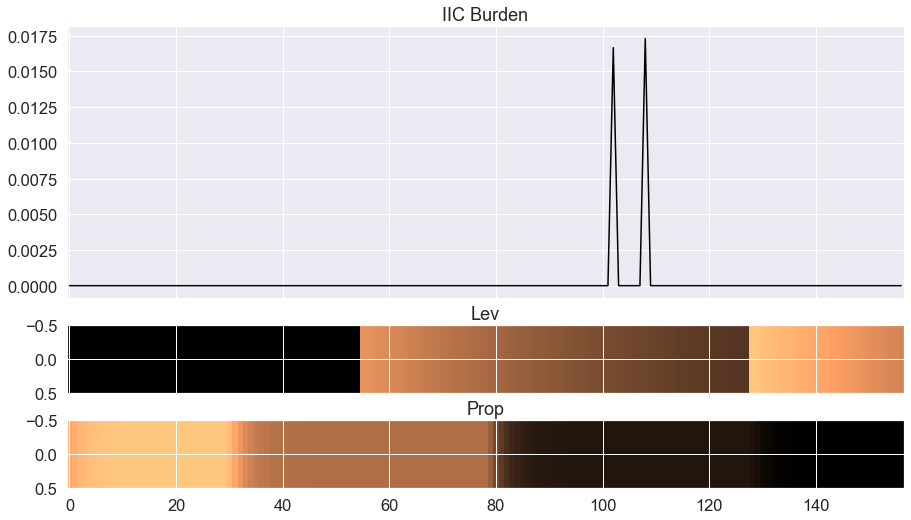

In [239]:
plot_u(8)

In [92]:
df.T.index

Index(['Gender', 'Age', 'Marrital', 'iGCS-Total', 'iGCS = T?',
       'Worst GCS in 1st 24h', 'Worst GCS intub', 'APACHE II 1st 24h',
       'SBP highest (1st 24h)', 'SBP lowest (1st 24h)',
       'DBP highest (1st 24h)', 'DBP lowest (1st 24h)',
       'HR highest (1std 24h)', 'HR lowest (1st 24h)', 'Surgery', 'Hx CVA',
       'Hx HTN', 'Hx Sz', 'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
       'Hx DM', 'Hx HLD', 'Hx PUD', 'Hx liver failure', 'Hx smoking',
       'Hx alcohol', 'Hx substance abuse', 'Hx cancer', 'Hx CNS cancer',
       'Hx PVD', 'Hx dementia', 'Hx COPD/Asthma', 'Hx leukemia/lymphoma',
       'Hx AIDs', 'Hx CTD', 'premorbid MRS', 'OSH time 1st AED', 'CA (PEA)',
       'Sz at presentation', 'EEG day1 MV', 'EEG day1 GCS', 'EEG day1 sysBP',
       'acute SDH', 'Sepsis/Shock', 'NeuroDx:IschStroke', 'NeuroDx:HemStroke',
       'NeuroDx:SAH', 'NeuroDx:SDH', 'NeuroDx:SDH+TBI(SAH)',
       'NeuroDx:TBI(SAH)', 'NeuroDx:Sz/SE', 'NeuroDx:Brain tumor',
       'NeuroDx:CNS 

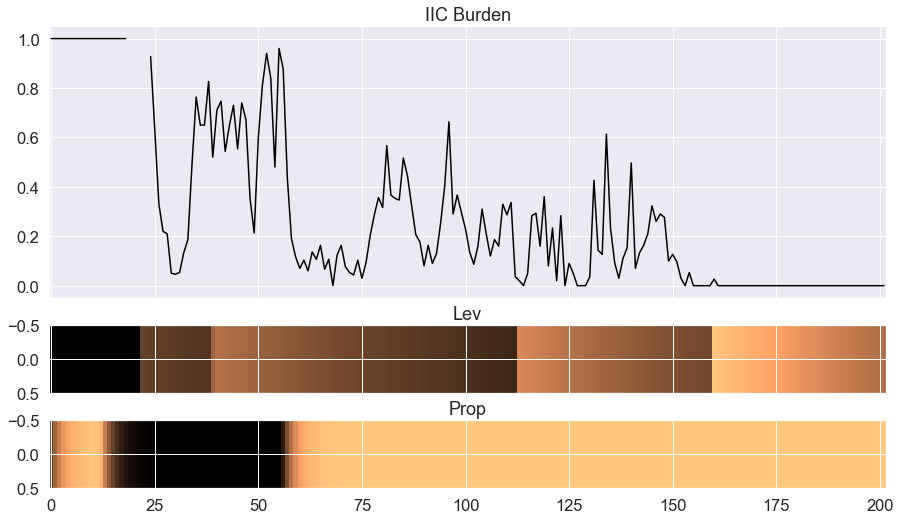

In [247]:
plot_u(25)